Install missing modules and imports

In [1]:
import sys
import subprocess
import pkg_resources

required = {'scipy', 'numpy', 'pandas', 'openpyxl', 'scikit-learn', 'numba', 'matplotlib','jupyter', 'nbconvert'}
installed = {pkg.key for pkg in pkg_resources.working_set}
missing = required - installed

if missing:
    python = sys.executable
    subprocess.check_call([python, '-m', 'pip', 'install', *missing], stdout=subprocess.DEVNULL)

import pandas as pd
import numpy as np
import math
from sklearn.model_selection import train_test_split
import numba as nb
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from sys import argv


Transform to PD

In [2]:
'''
[t1,t2, t3 ,.... t3000] train
[[t11,t12,t13,..t110],[t21, t22,..], ... [t31,...t310]]
[Ku1, Ku2, Ku3, ...] [Kd1, Kd2, ...] D1 ,[Ku1, Ku2, Ku3, ...] [Kd1, Kd2, ...] D2 ...
[t3000,t2, t3 ,.... t5000] test
[[t11,t12,t13,..t110],[t21, t22,..], ... [t31,...t310]]
Teta la quantité à vendre ou à acheter 
t11 et t12 => Teta 1 (Ku, Kd, St) = Lamda * g(t+1, Ku*St) + (1-Lamda)* g(t+1, Kd*St) /(Ku - Kd) * St
Ku1 = max(Ku1i) par rapport à i la dizaine
supp Ft1 = [min sur les d (Kd1), max sur les d (Ku1)] 
supp Ft2 = [min sur les d (Kd2), max sur les d (Ku2)]
supp Ft (St+1) = [Kd*St;Ku*St]
vend un call -> t = 0, prime V = 0 => V = Prix call - CALL -> Achat vente d'action ou d'autres investissement -> VT , 
(ST - K)+ 
1- VT < (ST - K)+
2- VT > (ST - K) + => VT - (ST - K)+
[t3001,...t4999] test
'''

"\n[t1,t2, t3 ,.... t3000] train\n[[t11,t12,t13,..t110],[t21, t22,..], ... [t31,...t310]]\n[Ku1, Ku2, Ku3, ...] [Kd1, Kd2, ...] D1 ,[Ku1, Ku2, Ku3, ...] [Kd1, Kd2, ...] D2 ...\n[t3000,t2, t3 ,.... t5000] test\n[[t11,t12,t13,..t110],[t21, t22,..], ... [t31,...t310]]\nTeta la quantité à vendre ou à acheter \nt11 et t12 => Teta 1 (Ku, Kd, St) = Lamda * g(t+1, Ku*St) + (1-Lamda)* g(t+1, Kd*St) /(Ku - Kd) * St\nKu1 = max(Ku1i) par rapport à i la dizaine\nsupp Ft1 = [min sur les d (Kd1), max sur les d (Ku1)] \nsupp Ft2 = [min sur les d (Kd2), max sur les d (Ku2)]\nsupp Ft (St+1) = [Kd*St;Ku*St]\nvend un call -> t = 0, prime V = 0 => V = Prix call - CALL -> Achat vente d'action ou d'autres investissement -> VT , \n(ST - K)+ \n1- VT < (ST - K)+\n2- VT > (ST - K) + => VT - (ST - K)+\n[t3001,...t4999] test\n"

In [3]:
file = 'data.xlsx'
df = [pd.read_excel(file, sheet_name = sheet) for sheet in ['CAC', 'DAX', 'IBEX35TR', 'IBEX', 'SX5E', 'SX5T', 'SMI']]
for i in range(len(df)):
    df[i] = df[i].drop(0)

Helpers

In [4]:
@nb.jit(nb.float64(nb.float64, nb.float64), nopython = True)
#A : Payoff, B: VT
def erreur(A, B):
    return abs(min(B - A,0)) - max(B-A,0)
@nb.jit(nb.float64(nb.float64, nb.float64), nopython = True)
def g(x, K):
    return max(x-K, 0)

def Calculate_Kd_Ku(L):
    Ku = np.ones(len(L))
    Kd = np.ones(len(L))
    for j in range(len(L)):
        if L.iloc[j]['S1/S'] > Ku[j] :
            Ku[j] = L.iloc[j]['S1/S']
        if L.iloc[j]['S1/S'] < Kd[j] :
            Kd[j] = L.iloc[j]['S1/S']
                
    return Ku, Kd
def Ku_Kd_Train(Data_train):
    Kus = []
    Kds = []
    for i in range(len(Data_train)):
        Ku_, Kd_ = Calculate_Kd_Ku(Data_train[i])
        Kus.append(max(Ku_))
        Kds.append(min(Kd_))
    return Kus, Kds 


Black & Scholes

In [5]:
from scipy import stats

def bsm_price(option_type, sigma, s, k, r, T):
    sigma = float(sigma)
    d1 = (np.log(s / k) + (r + sigma ** 2 * 0.5) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == 'c':
        price = np.exp(-r*T) * (s * np.exp((r)*T) * stats.norm.cdf(d1) - k *  stats.norm.cdf(d2))
        return price
    elif option_type == 'p':
        price = np.exp(-r*T) * (k * stats.norm.cdf(-d2) - s * np.exp((r)*T) *  stats.norm.cdf(-d1))
        return price
    else:
        print('No such option type %s') %option_type

Split data train test

Méthode I : Variante Min sur Dizaine

In [6]:
CAC_40 = df[0].iloc[:len(df[0])-len(df[0])%10]
#p un pourcentage de Train % Test
#n nombre de jour au total dans le cycle Train + Test
#L de la forme dataframe des données de chaque jour
def create_train_test(L,p,n):
    CAC_40_split = np.array_split(L,len(L)/(n))
    CAC_40_split = [CAC_40_split[i].iloc[:len(CAC_40_split[i]) - len(CAC_40_split[i])%10] for i in range(len(CAC_40_split))]
    Data_train = []
    Data_test = []
    for i in range(len(CAC_40_split)):
        ind = max(10,int(p*len(CAC_40_split[i]) - p*len(CAC_40_split[i])%10))
        Data_train.append(CAC_40_split[i].iloc[:ind])
        Data_test.append(CAC_40_split[i].iloc[ind:int(len(CAC_40_split[i]))])
    return Data_train, Data_test

Calcul de Ku, Kd

In [7]:
#L de la forme [[s1,s2,s3,...,sn], [s1,s2,s3,...], [s1,s2,s3,...], ...]
def test(L, Ku, Kd, K):
    lamda = [(1 - Kd[i])/(Ku[i] - Kd[i]) for i in range(len(Ku))]
    sum_err = 0
    BS_qs = []
    VTs = []
    PAYOFFs = []
    Errs = []
    STs = []
    V0s = []
    max_err = -math.inf
    for i in range(len(L)):
        D = []
        BS_q = []
        for j in range(len(L[i])):
            if j == 0:
                D.append(bsm_price('c', L[i]['PX_LAST'].std(), L[i].iloc[j]['PX_LAST'], K, 0, len(L[i])/365.25))
                V0s.append(D[-1])
            else:
                Teta = (g(Ku[i]*L[i].iloc[j]['PX_LAST'], K)*lamda[i] + g(Kd[i]*L[i].iloc[j]['PX_LAST'], K)*(1-lamda[i]))/((Ku[i]-Kd[i])*L[i].iloc[j]['PX_LAST'])
                D.append(D[-1] + Teta*L[i].iloc[j]['D_S'])
                BS_q.append(Teta)
        VT = D[-1]
        ST = L[i].iloc[len(L[i])-1]['PX_LAST']
        PAYOFF = g(ST, K)
        err = erreur(PAYOFF, VT)/len(L[i])
        sum_err += err
        max_err = max(max_err, err)
        BS_qs.append(BS_q)
        Errs.append(err)
        VTs.append(VT)
        PAYOFFs.append(PAYOFF)
        STs.append(ST)
    return sum_err, VTs, PAYOFFs, STs, BS_qs, Errs, max_err, V0s

In [8]:
#data sous forme dataframe des données journalières
#K strike
#n nombre total de jours dans un cycle Train + Test multiple de 10
#p pourcentage train % test
def train_test(data, K, n, p):
    Data_train, Data_test = create_train_test(data, p, n)
    Kus, Kds = Ku_Kd_Train(Data_train)
    sum_error, VTs, PAYOFFs, STs, BS_qs, Errs, max_err, V0s = test(Data_test, Kus, Kds, K)
    return n, p, sum_error, VTs, PAYOFFs, STs, BS_qs, Errs, max_err, Data_train, Data_test, V0s

In [9]:
val_min = math.inf
MAP = []
Results = []
for i in range(0,100,10):
    for j in range(20,250,10):
        sol = train_test(CAC_40, 3500, j, i/100)
        Results.append(sol)
        MAP.append([sol[0],sol[1],sol[2]])
        if sol[2] < val_min:
            val_min = sol[2]
            sol_fi = sol



In [10]:
MAPs = [[elem[i] for elem in MAP] for i in range(len(MAP[0]))]
file_df = pd.DataFrame()
file_df['n'] = np.array(MAPs[0])
file_df['p'] = np.array(MAPs[1])
file_df['sum_error'] = np.array(MAPs[2])
file_df.to_csv('output.csv', index = False)


        DATES  DELTA_DAYS  PX_LAST  PX_HIGH   PX_LOW  PX_VOLUME      S1/S  \
31 2001-01-03           1  5684.05  5767.65  5631.32   53443710  0.980195   
32 2001-01-04           1  5815.99  5884.01  5764.88   75682610  1.023212   
33 2001-01-05           1  5758.02  5862.04  5733.48   61398680  0.990033   
34 2001-01-08           3  5732.80  5757.50  5695.19   40967380  0.995620   
35 2001-01-09           1  5663.19  5792.56  5627.86   64687970  0.987858   
36 2001-01-10           1  5653.35  5686.24  5603.92   50266650  0.998262   
37 2001-01-11           1  5702.78  5702.93  5631.89   49992520  1.008743   
38 2001-01-12           1  5834.34  5841.82  5738.50   76458540  1.023069   
39 2001-01-15           3  5833.38  5853.88  5795.88   32777620  0.999835   
40 2001-01-16           1  5761.67  5838.41  5749.07   53144890  0.987707   

       D_S  
31 -114.85  
32  131.94  
33  -57.97  
34  -25.22  
35  -69.61  
36   -9.84  
37   49.43  
38  131.56  
39   -0.96  
40  -71.71  
6413.7865

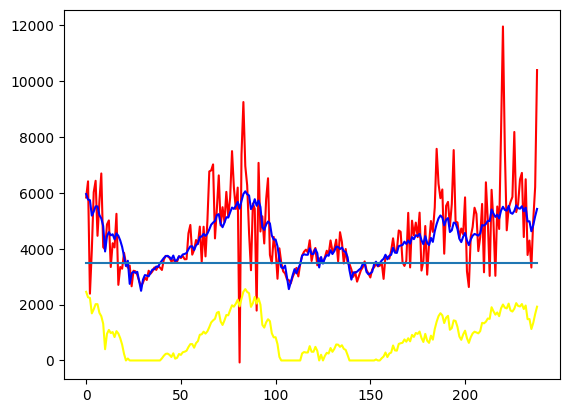

VT - PAYOFF


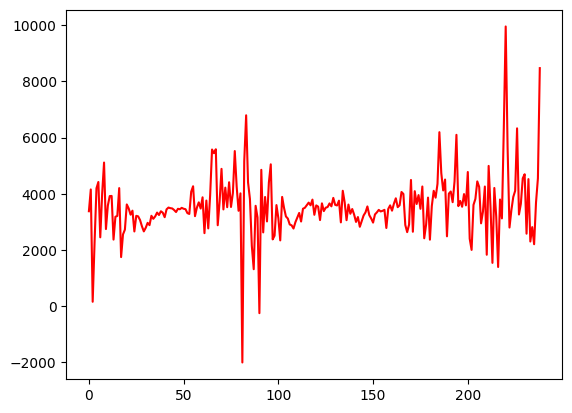

Cumulative Error
max Error
200.88349789176138
p & n
0.0
20


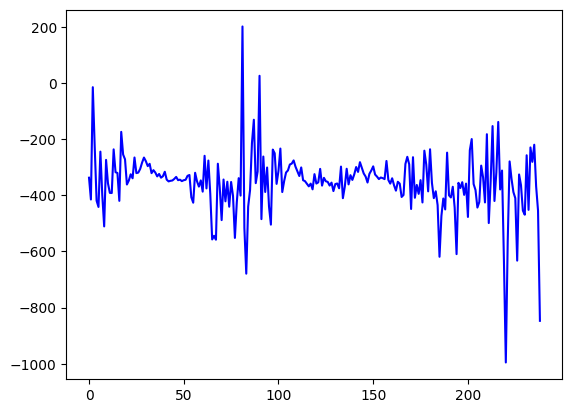

In [11]:
n, p, error, VTs, PAYOFFs, STs, BS_qs, Errs, max_err, train_dt, test_dt, V0s = sol_fi

print(test_dt[1])
print(VTs[1])
print(PAYOFFs[1])
print(BS_qs[1])
print("red : VT, yellow : PAYOFF, blue : ST, line : K")
plt.plot(VTs, color = 'red')
plt.plot(PAYOFFs, color = 'yellow')
plt.plot(STs, color = 'blue')
plt.plot([3500 for i in range(len(STs))])
plt.show()
print("VT - PAYOFF")
plt.plot(np.array(VTs) - np.array(PAYOFFs), color = 'red')
plt.show()
print("Cumulative Error")
plt.plot(Errs, color = 'blue')

print("max Error")
print(max_err)
print("p & n")
print(p)
print(n)

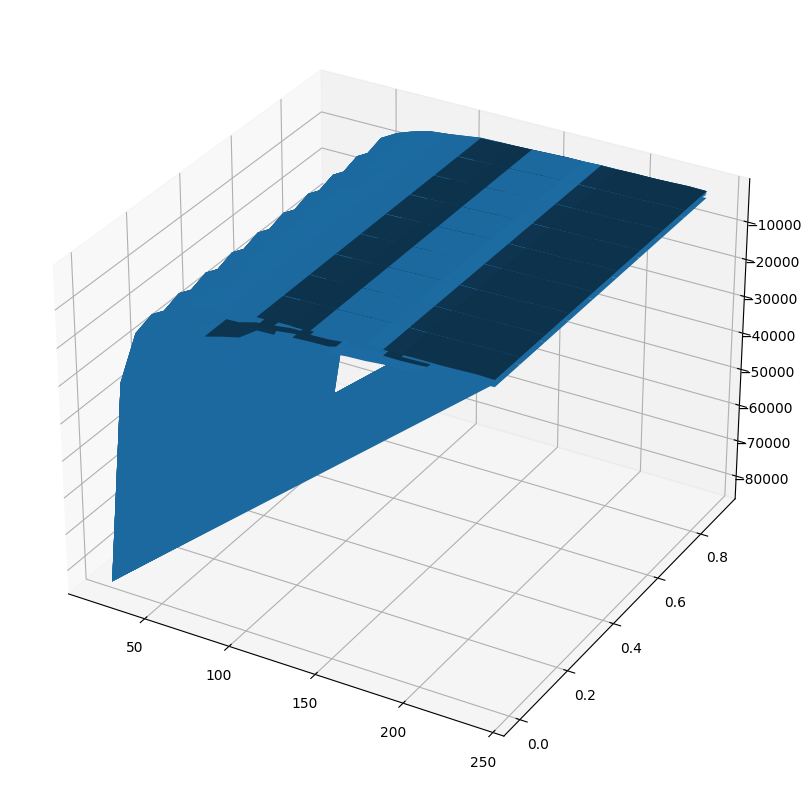

In [12]:

fig = plt.figure(figsize=(10,15))
X, Y = np.meshgrid(MAPs[0],MAPs[1])
Z = np.array([MAPs[2]])
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z)
plt.show()
